In [2]:
import xarray as xr
#from aostools.climate import ComputeMeridionalPVGrad, ComputeRefractiveIndex, ComputeEPfluxDiv
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
#import shapely.geometry as sgeom
#import glob
#from averaging import xarray_average
#import xarray.ufuncs as xrf
#import detect_peaks as dp
#from bokeh.plotting import figure, output_file, show, output_notebook
#from bokeh.models import HoverTool, ColumnDataSource, CrosshairTool
import pandas as pd
#import peakutils.peak
import shapely.geometry as sgeom
from string import ascii_lowercase, ascii_uppercase
from statsmodels.stats.multitest import fdrcorrection

%matplotlib inline

# Options

In [3]:
plt.rcParams.update({'font.size': 22})
xr.set_options(keep_attrs=True,display_style='html')

In [4]:
timescale = 20
DJF_bool = '_DJFonly'
root_path = '/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily/'
root_path = '/mnt/data04/model/CMAM/0A.daily/'
cesta = f'{root_path}composites_woSSW{DJF_bool}/'

In [5]:
var = 'toz'
what = 'anomalies'#'percentages' A
e_type = 'himalayas'
timescale = 20

In [6]:
if e_type == 'himalayas':
    box = sgeom.box(minx=70, maxx=102.5, miny=20, maxy=40)
    zoomin_extent = [0,180,10,80]
    central_longitude = 90

elif e_type == 'eastasia':
    box = sgeom.box(minx=110, maxx=145, miny=27.5, maxy=52)
    zoomin_extent = [0,180,10,80]
    central_longitude = 90

elif e_type == 'westamer':
    box = sgeom.box(minx=-125, maxx=-102.5, miny=27.5, maxy=52)
    zoomin_extent = [-180,0,10,80]
    central_longitude = 270
    
box_lats = np.array(box.bounds)[1::2]
box_lons = np.array(box.bounds)[::2]
box_lons[box_lons < 0] += 360

# Data loading

In [7]:
da = xr.open_dataarray('{}{}_{}_comp_{}_{}days.nc'.format(cesta, var, what, e_type, timescale))
da.attrs['units'] = 'DU'
da.attrs['long_name'] = 'total column ozone'
da

<xarray.DataArray 'toz' (lag: 21, lat: 48, lon: 96)>
array([[[-1.942375, -1.973632, ..., -1.904322, -1.91905 ],
        [-2.467235, -2.626476, ..., -2.159464, -2.312122],
        ...,
        [ 9.362869,  9.255806, ...,  9.777782,  9.53985 ],
        [12.411675, 12.494932, ..., 12.290566, 12.342963]],

       [[-2.826644, -2.831244, ..., -2.850933, -2.833223],
        [-3.448255, -3.605703, ..., -3.192594, -3.310846],
        ...,
        [ 9.479692,  9.34197 , ...,  9.881291,  9.660975],
        [13.764913, 13.687374, ..., 13.956762, 13.854789]],

       ...,

       [[-2.611665, -2.574448, ..., -2.704751, -2.655365],
        [-2.97065 , -2.818811, ..., -3.269937, -3.122267],
        ...,
        [20.632166, 20.793726, ..., 20.586767, 20.565334],
        [24.926107, 25.002011, ..., 24.875911, 24.884215]],

       [[-2.247936, -2.274234, ..., -2.210149, -2.226738],
        [-2.798029, -2.681622, ..., -3.096607, -2.938062],
        ...,
        [24.647214, 24.342557, ..., 25.481923, 25.029294],
        [29.351322, 29.388459, ..., 29.335422, 29.334135]]])
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10
Attributes:
    units:      DU
    long_name:  total column ozone

In [8]:
its = 10000
da_pv = xr.open_dataarray(f'{cesta}{var}_pvalues_from{its}_comp_{e_type}_{timescale}days.nc')
da_pv

<xarray.DataArray 'toz' (lat: 48, lon: 96, lag: 21)>
array([[[7.263713e-02, 7.048026e-02, ..., 7.108432e-02, 7.189036e-02],
        [7.243832e-02, 7.043519e-02, ..., 7.108401e-02, 7.170633e-02],
        ...,
        [7.292926e-02, 7.037360e-02, ..., 7.088299e-02, 7.215810e-02],
        [7.279841e-02, 7.046117e-02, ..., 7.101847e-02, 7.204011e-02]],

       [[7.521984e-02, 6.936615e-02, ..., 7.239915e-02, 7.339869e-02],
        [7.467315e-02, 6.833122e-02, ..., 7.357229e-02, 7.436428e-02],
        ...,
        [7.616784e-02, 7.000018e-02, ..., 6.958543e-02, 7.051712e-02],
        [7.567333e-02, 6.992790e-02, ..., 7.102991e-02, 7.207922e-02]],

       ...,

       [[2.910340e-02, 2.829354e-02, ..., 8.563553e-04, 1.332578e-04],
        [2.964951e-02, 2.905184e-02, ..., 7.363243e-04, 1.745308e-04],
        ...,
        [2.727287e-02, 2.657623e-02, ..., 9.451657e-04, 8.465113e-05],
        [2.835472e-02, 2.752085e-02, ..., 9.190131e-04, 1.153333e-04]],

       [[1.755308e-02, 1.316313e-02, ..., 1.926592e-04, 1.144512e-06],
        [1.717201e-02, 1.325772e-02, ..., 2.004470e-04, 1.028044e-06],
        ...,
        [1.811492e-02, 1.284311e-02, ..., 1.696028e-04, 1.398249e-06],
        [1.786254e-02, 1.302473e-02, ..., 1.818341e-04, 1.257826e-06]]])
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10

# Visualization

In [9]:
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"
weights


<xarray.DataArray 'weights' (lat: 48)>
array([0.04956284, 0.11356847, 0.17747903, 0.24073214, 0.30300897,
       0.36403136, 0.42353629, 0.48127071, 0.53699055, 0.59046096,
       0.64145695, 0.68976415, 0.7351796 , 0.77751257, 0.81658534,
       0.85223389, 0.88430859, 0.91267484, 0.9372136 , 0.95782191,
       0.97441328, 0.98691811, 0.99528392, 0.99947562, 0.99947562,
       0.99528392, 0.98691811, 0.97441328, 0.95782191, 0.9372136 ,
       0.91267484, 0.88430859, 0.85223389, 0.81658534, 0.77751257,
       0.7351796 , 0.68976415, 0.64145695, 0.59046096, 0.53699055,
       0.48127071, 0.42353629, 0.36403136, 0.30300897, 0.24073214,
       0.17747903, 0.11356847, 0.04956284])
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      latitude
    standard_name:  latitude

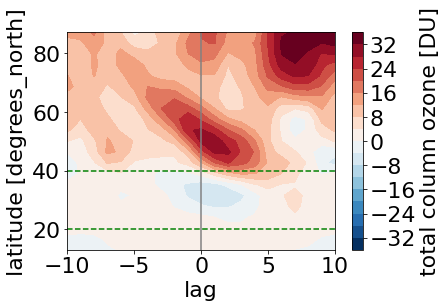

In [77]:
da.sel(
    lon = slice(80,130),
    lat = slice(10,None)
).weighted(weights).mean('lon').plot.contourf(
    x = 'lag', 
    levels = 21,
    robust = True
)
plt.hlines(list(box.bounds)[1::2],-10,10, color = 'green', linestyles='--')
plt.vlines(0,13,87, color ='gray')

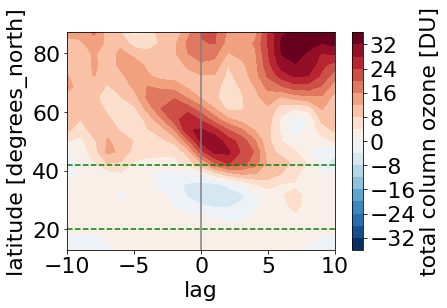

In [72]:
da.sel(
    lon = slice(80,130),
    lat = slice(10,None)
).mean('lon').plot.contourf(
    x = 'lag', 
    levels = 21,
    robust = True
)
plt.hlines(list(box.bounds)[1::2],-10,10, color = 'green', linestyles='--')
plt.vlines(0,13,87, color ='gray')

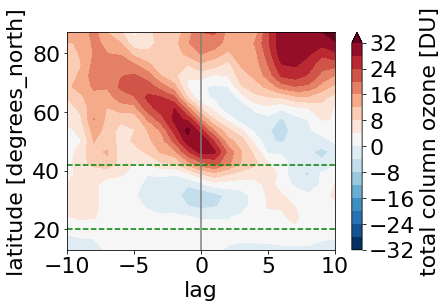

In [73]:
da.sel(
    lon = slice(70,105),
    lat = slice(10,None)
).weighted(weights).mean('lon').plot.contourf(
    x = 'lag', 
    levels = 21,
    robust = True
)
plt.hlines(list(box.bounds)[1::2],-10,10, color = 'green', linestyles='--')
plt.vlines(0,13,87, color ='gray')

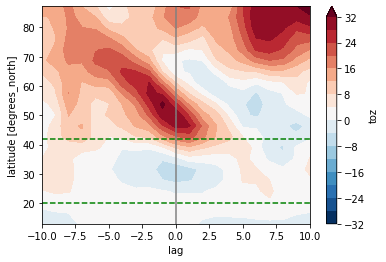

In [41]:
da.sel(
    lon = slice(70,105),
    lat = slice(10,None)
).mean('lon').plot.contourf(
    x = 'lag', 
    levels = 21,
    robust = True
)
plt.hlines(list(box.bounds)[1::2],-10,10, color = 'green', linestyles='--')
plt.vlines(0,13,87, color ='gray')

## Maps

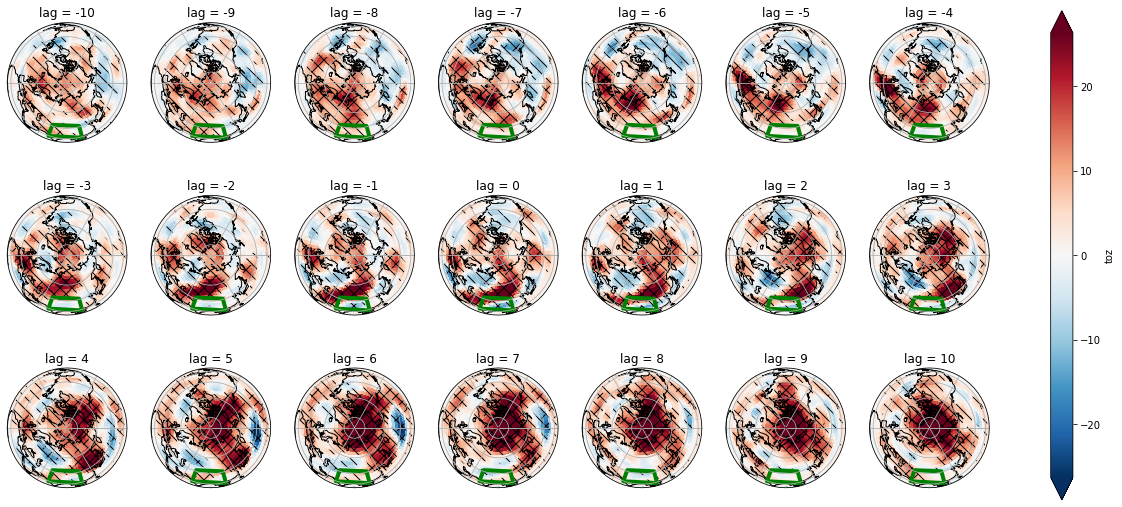

In [29]:
projection = ccrs.Orthographic(central_longitude, 90)
p = da.plot(col = 'lag', col_wrap=7, transform=ccrs.PlateCarree(), \
            subplot_kws={'projection': projection}, robust = True)


for ax, sel_dict in zip(p.axes.flat, p.name_dicts.flat):
    ax.coastlines()
    ax.gridlines()
    ax.add_geometries([box], ccrs.PlateCarree(), \
                      facecolor=['none'], edgecolor=['green'], \
                      linewidth = [4])
    plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False,
                     ax=ax,  transform=ccrs.PlateCarree())
    da_pv.sel(**sel_dict).plot.contourf(**plot_kwargs)
    plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], \
                                    colors='none', add_colorbar=False,
                        ax=ax,  transform=ccrs.PlateCarree())
    da_pv.sel(**sel_dict).plot.contourf(**plot_kwargs)
    

### Selected lags

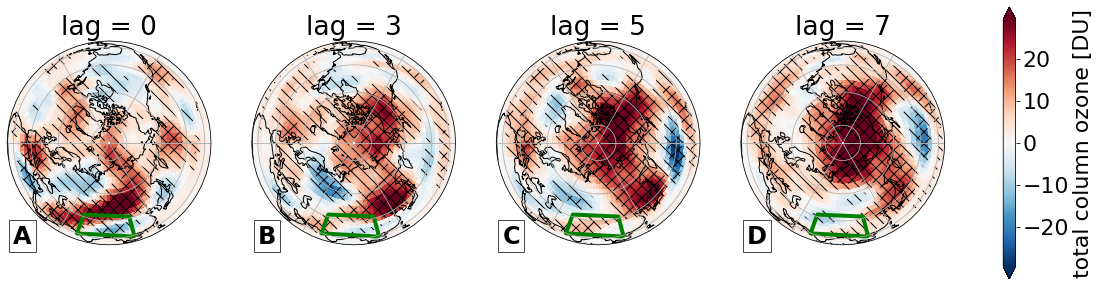

In [53]:
projection = ccrs.Orthographic(central_longitude, 90)
p = da.sel(lag = [0,3,5,7]).plot(col = 'lag', size = 5, transform=ccrs.PlateCarree(), \
            subplot_kws={'projection': projection}, robust = True)


for i, (ax, sel_dict) in enumerate(zip(p.axes.flat, p.name_dicts.flat)):
    ax.coastlines()
    ax.gridlines()
    ax.add_geometries([box], ccrs.PlateCarree(), \
                      facecolor=['none'], edgecolor=['green'], \
                      linewidth = [4])
    plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False,
                     ax=ax,  transform=ccrs.PlateCarree())
    da_pv.sel(**sel_dict).plot.contourf(**plot_kwargs)
    plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], \
                                    colors='none', add_colorbar=False,
                        ax=ax,  transform=ccrs.PlateCarree())
    da_pv.sel(**sel_dict).plot.contourf(**plot_kwargs)
    
    ax.text(0.03, 0.1, ascii_uppercase[i], transform=ax.transAxes,
                      fontsize=24, fontweight='bold', va='top', 
            bbox={'alpha': 0.7, 'facecolor': 'white'})
    

#### FDR

In [15]:
temp

<xarray.DataArray 'toz' (z: 18432)>
array([0.07585462, 0.0763558 , 0.07686099, ..., 0.00026979, 0.00027023,
       0.00026534])
Coordinates:
  * z        (z) MultiIndex
  - lag      (z) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 7 7 7 7 7 7 7 7 7 7 7
  - lat      (z) float64 -87.16 -87.16 -87.16 -87.16 ... 87.16 87.16 87.16 87.16
  - lon      (z) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

In [14]:
temp = da_pv.sel(lag = [0,3,5,7]).stack(
    z=('lag','lat', 'lon')
)
fdr = fdrcorrection(temp)
fdr_pv = xr.DataArray(fdr[1], coords = temp.coords).unstack()
fdr_pv

<xarray.DataArray (lag: 4, lat: 48, lon: 96)>
array([[[0.11806109, 0.11811649, 0.1181686 , ..., 0.11792977,
         0.11792977, 0.11806109],
        [0.11854402, 0.11831095, 0.1181686 , ..., 0.11985554,
         0.11946021, 0.11897961],
        [0.11792977, 0.11792977, 0.11792977, ..., 0.1180827 ,
         0.11792977, 0.11792977],
        ...,
        [0.11792977, 0.11792977, 0.11792977, ..., 0.11792977,
         0.11792977, 0.11792977],
        [0.11792977, 0.11792977, 0.11792977, ..., 0.11792977,
         0.11792977, 0.11792977],
        [0.08510106, 0.08387107, 0.08238874, ..., 0.08580766,
         0.08585943, 0.08570925]],

       [[0.1181686 , 0.11822737, 0.11826273, ..., 0.11811649,
         0.11814626, 0.1181686 ],
        [0.11846957, 0.1187079 , 0.11897961, ..., 0.11792977,
         0.11806109, 0.1181686 ],
        [0.11846957, 0.11809474, 0.11792977, ..., 0.11897961,
         0.1207962 , 0.11975711],
...
        [0.02301777, 0.01931621, 0.01744836, ..., 0.04379509,
         0.03612993, 0.02934861],
        [0.0156906 , 0.01428589, 0.01233039, ..., 0.02398883,
         0.02062017, 0.01757042],
        [0.02187234, 0.02098941, 0.0201294 , ..., 0.02458088,
         0.02374687, 0.02278607]],

       [[0.11792977, 0.11792977, 0.11792977, ..., 0.11792977,
         0.11792977, 0.11792977],
        [0.11792977, 0.11792977, 0.11792977, ..., 0.11792977,
         0.11792977, 0.11792977],
        [0.11792977, 0.11792977, 0.11792977, ..., 0.11792977,
         0.11792977, 0.11792977],
        ...,
        [0.01714905, 0.01491485, 0.01214645, ..., 0.02196192,
         0.02105665, 0.01896385],
        [0.01043742, 0.00832252, 0.00606199, ..., 0.01307275,
         0.0127994 , 0.0119302 ],
        [0.00474207, 0.00464811, 0.00463197, ..., 0.00488968,
         0.00489281, 0.00483746]]])
Coordinates:
  * lag      (lag) int64 0 3 5 7
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2

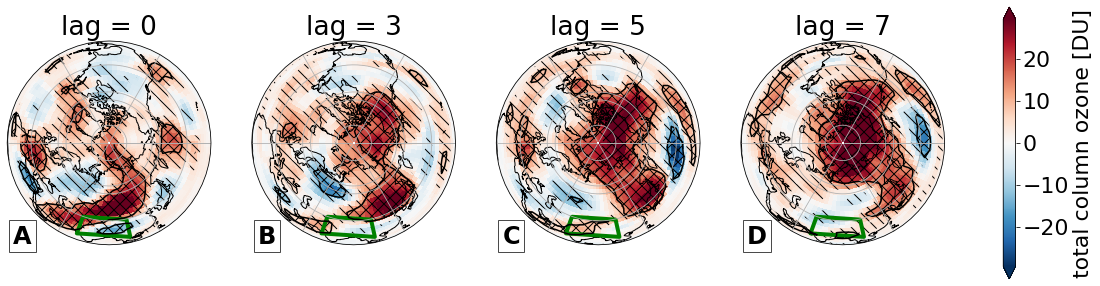

In [13]:
projection = ccrs.Orthographic(central_longitude, 90)
p = da.sel(lag = [0,3,5,7]).plot(col = 'lag', size = 5, transform=ccrs.PlateCarree(), \
            subplot_kws={'projection': projection}, robust = True)


for i, (ax, sel_dict) in enumerate(zip(p.axes.flat, p.name_dicts.flat)):
    ax.coastlines()
    ax.gridlines(ylocs=[40,60,65,80])
    ax.add_geometries([box], ccrs.PlateCarree(), \
                      facecolor=['none'], edgecolor=['green'], \
                      linewidth = [4])
    plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False,
                     ax=ax,  transform=ccrs.PlateCarree())
    da_pv.sel(**sel_dict).plot.contourf(**plot_kwargs)
    plot_kwargs = dict(levels = [0,0.01], hatches=['//',None], \
                                    colors='none', add_colorbar=False,
                        ax=ax,  transform=ccrs.PlateCarree())
    da_pv.sel(**sel_dict).plot.contourf(**plot_kwargs)
    plot_kwargs = dict(levels = [0,0.05], colors='k', \
                           add_colorbar=False, \
                        ax=ax,  transform=ccrs.PlateCarree())
    fdr_pv.sel(**sel_dict).plot.contour(**plot_kwargs)
    
    ax.text(0.03, 0.1, ascii_uppercase[i], transform=ax.transAxes,
                      fontsize=24, fontweight='bold', va='top', 
            bbox={'alpha': 0.7, 'facecolor': 'white'})
#plt.savefig('TO3_anomalies_lagA_FDR.pdf', bbox_inches = 'tight')